In [1]:
import functools

import cv2
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

In [2]:
def gaussian_kernel(k, std):
    half = (k - 1) / 2
    raw_filter = sp.stats.norm.pdf(np.arange(-half, half + 1), scale=std)
    normalized = raw_filter / raw_filter.sum()
    return normalized

In [3]:
def apply_kernel(kernel, image):
    convolved = [sp.signal.convolve2d(image[..., ch], kernel) for ch in range(image.shape[-1])]
    stacked = np.stack(convolved, -1).astype(np.uint8)
    return stacked

In [4]:
def gaussian_blurrer(k_size, sigma):
    f = gaussian_kernel(k_size, sigma)
    kernel = np.outer(f, f)

    return functools.partial(apply_kernel, kernel)

In [5]:
def imshow(image):
    # return
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

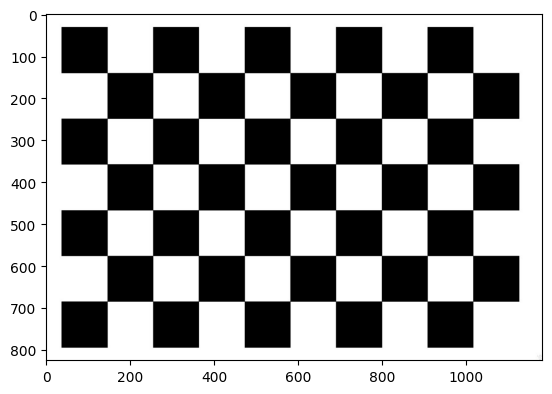

In [6]:
img = cv2.imread('chessboard-hw1.jpg')
imshow(img)

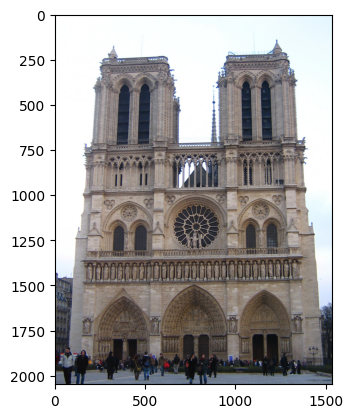

In [7]:
img2 = cv2.imread('1a_notredame.jpg')
imshow(img2)

In [8]:
blurrer5x5 = gaussian_blurrer(5, 5)
blurrer10x10 = gaussian_blurrer(10, 5)

In [9]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [227, 225, 225],
        [251, 249, 249],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [253, 251, 251],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [252, 250, 250],
        [255, 254, 254],
        [255, 255, 255]]

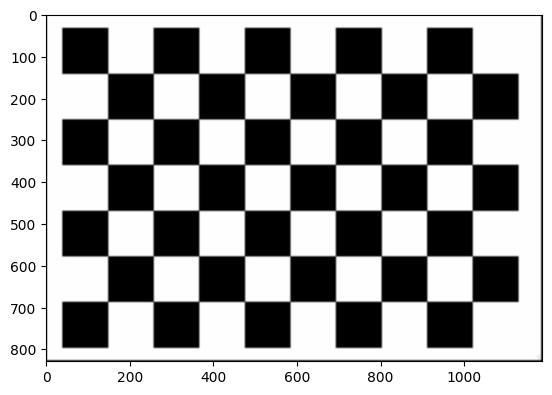

In [10]:
blurred_img5x5 = blurrer5x5(img)
imshow(blurred_img5x5)

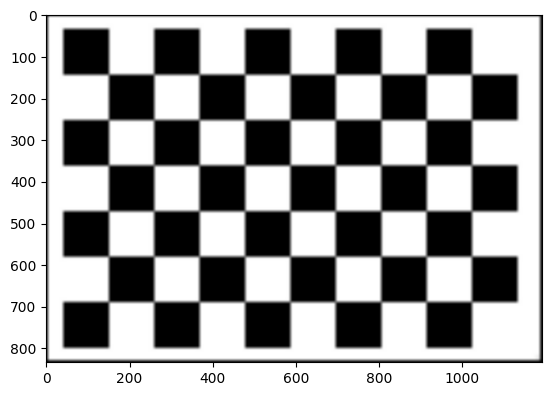

In [11]:
blurred_img10x10 = blurrer10x10(img)
imshow(blurred_img10x10)

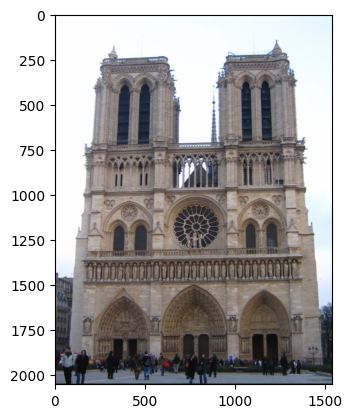

In [12]:
blurred_img25x5 = blurrer5x5(img2)
imshow(blurred_img25x5)

True

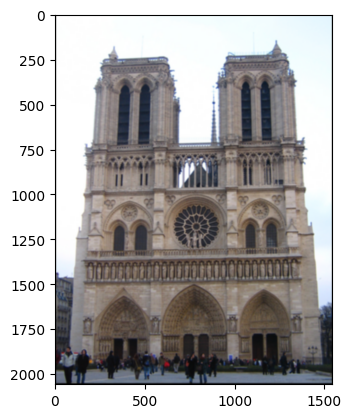

In [13]:
blurred_img210x10 = blurrer10x10(img2)
imshow(blurred_img210x10)
cv2.imwrite('blurred_img210x10.jpg', blurred_img210x10)

In [14]:
def sobel_filter():
    hx = np.array([[-1., 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
    hy = np.array([[1., 2, 1], [0, 0, 0], [-1, -2, -1]]) / 8
    return hy, hx   # since the direction is arctan(dy, dx)

In [43]:
def gradient_field(image, threshold=0):
    sobel = sobel_filter()
    gradient = [np.stack([sp.signal.convolve2d(image[..., ch], s)
                          for ch in range(image.shape[-1])], axis=-1)
                for s in sobel]
    magnitude = np.hypot(*gradient)
    direction = np.arctan2(*gradient)

    gradient[0][magnitude <= threshold] = 0.0
    gradient[1][magnitude <= threshold] = 0.0
    direction[magnitude <= threshold] = 0.0
    magnitude[magnitude <= threshold] = 0.0
    return gradient, magnitude, direction

In [44]:
def direction_in_hue(magnitude, direction):
    hsv = np.zeros(direction.shape, dtype=np.uint8)

    hsv[..., 0] = direction.mean(axis=-1) * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(magnitude.mean(axis=-1), None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

In [45]:
def show_gradient(magnitude, direction):
    rgb = direction_in_hue(magnitude, direction)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey='all')
    ax[0].imshow(magnitude / 32)
    ax[1].imshow(rgb)

(2059, 1547, 3)


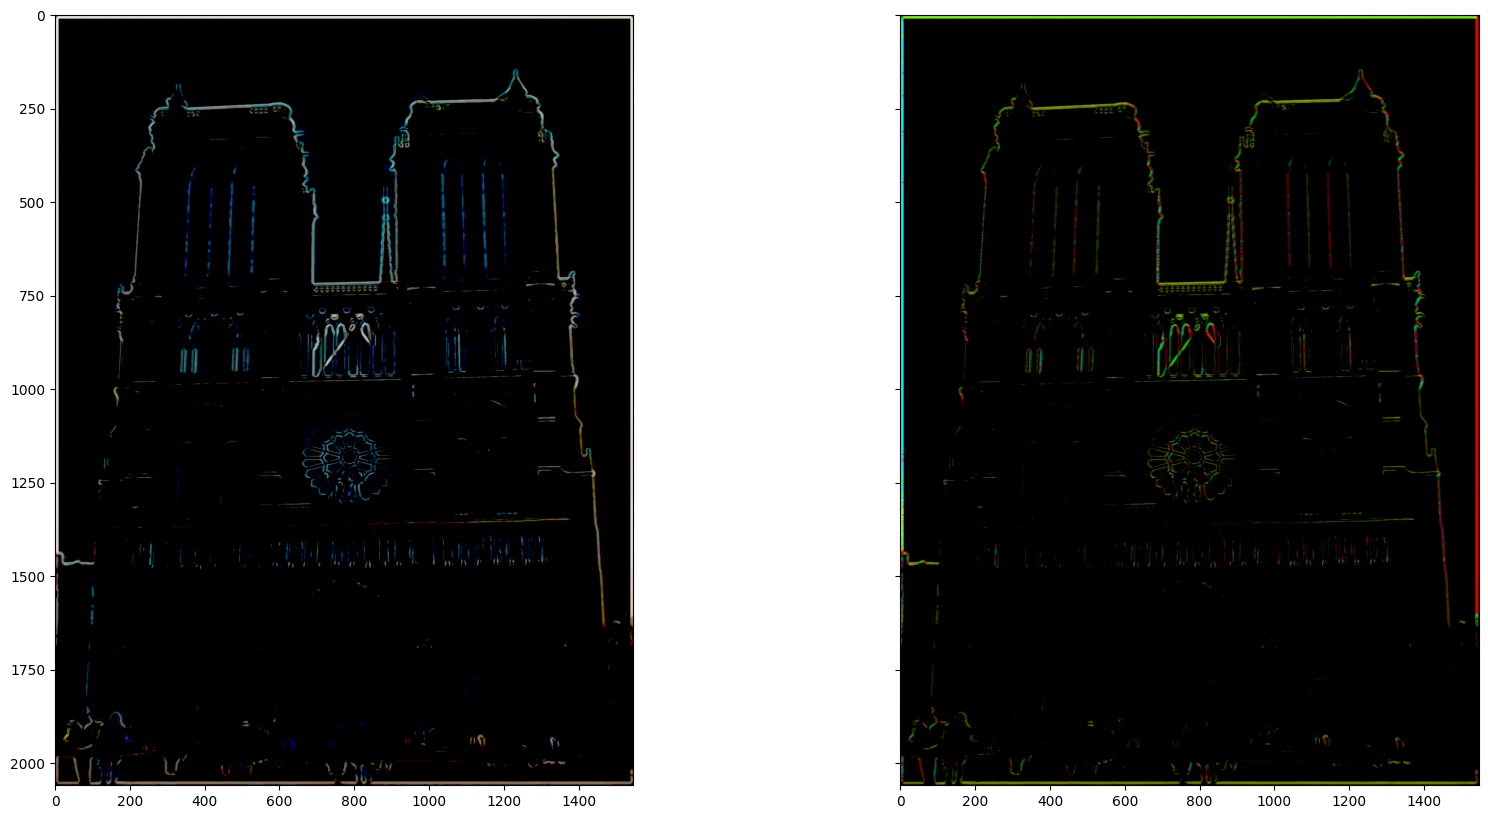

In [129]:
grad, mag, dire = gradient_field(blurred_img210x10, 10)
show_gradient(mag, dire)

In [130]:
# 1-3

In [131]:
def summation_kernel(size):
    k = np.ones((size, size))
    return functools.partial(apply_kernel, k)

In [132]:
def structure_tensor(gradient):
    Ixx = gradient[1] ** 2
    Ixy = gradient[0] * gradient[1]
    Iyy = gradient[0] ** 2

    return Ixx, Ixy, Iyy

In [133]:
def calc_eigen_minus(window, Ixx, Ixy, Iyy):
    Ixx = window(Ixx)
    Ixy = window(Ixy)
    Iyy = window(Iyy)

    det = Ixx * Iyy - Ixy * Ixy
    trace = Ixx + Iyy + 1e-5
    eigen_minus = det / trace
    return eigen_minus

In [134]:
window3x3 = summation_kernel(3)
window5x5 = summation_kernel(5)

In [135]:
Hs = structure_tensor(grad)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


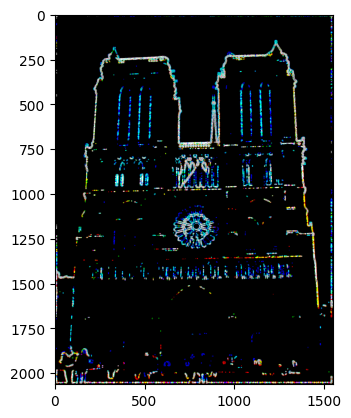

In [136]:
eigen_minus = calc_eigen_minus(blurrer5x5, *Hs)
plt.imshow(eigen_minus)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


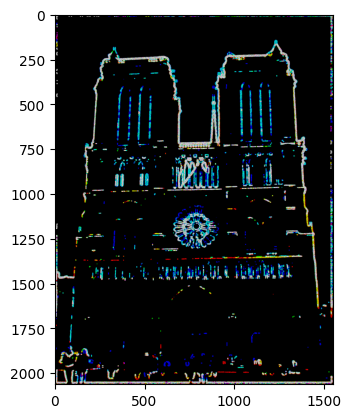

In [137]:
eigen_minus = calc_eigen_minus(window5x5, *Hs)
plt.imshow(eigen_minus)